## Modeling and Evaluation 1

In this Lab, we will investigate several different clustering algorithms and a variety of parameter combinations for each model.  In particular, Spectral Clustering, Hierarchical Agglomerative Clustering, HDBSCAN, Gaussian Mixture Models and KMEANS models will be produced.  Scatter plots and evaluation metrics; such as, silhouette score are generated during this step, which will aid in the evaluation and comparison of models in the Modeling and Evaluation 2 section.

##### Visualizations
Pitching statistics, Wins and ERA will typically be utilized for all cluster graphics. 
##### Groupings
Two natural grouping for Pitchers are a) starting pitchers and b) relievers.  The pitching data set does not differentiate pitchers in this manner.  All pitchers are simply given a position of "P".  Pitchers who are relievers can be further sub-divided into middle relievers and closers.  The assumption entering this section is showing clustering results using Wins and ERA will aid in providing clusters where the sub-divisions of pitchers (starters, relievers) may become evident.  

In [1]:
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture
import hdbscan
from sklearn.manifold import spectral_embedding
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import seaborn as sns
import itertools
from scipy import linalg
from sklearn.metrics import pairwise

import warnings
warnings.filterwarnings('ignore')

##### Importing Pitching data set - UnScaled
Importing the unscaled Pitching data set created in the Data Understanding step will be utilized in this section.  We will use the .pkl format.

In [2]:
pitching = pd.read_pickle("./analysisdata/pitching.pkl")
pitchingSv = pitching

#Create list to Consolidate Results of Clustering Models
clustResults = []

### Data Preprocessing
The output of data understanding was not intended to solve the needs of every clustering model.  As such, some data filtering steps will take place is this section to allow for flexible modeling.
##### Data Filtering - ERA Outliers and Year ID
As shown below, the range of ERA is from 0 to 139.5.  Typically, pitchers with a ERA over 6 do not have long careers in the Major Leagues.  However, there are instances where pitchers who represent major investments by a team are allowed to pitch with a higher ERA while gaining experience.  For example, Corey Kluber, who is a 2 time American League Cy Young winner (2014, 2017).  In his first season in the Major League, his ERA was 8.31.

To reduce unnecessary noise in the clustering model, a very generous rule of ERA less than 9 (one run per inning) will be implemented to restrict unnaturally high ERAs.  

The pitcher.pkl file has annual pitcher data dating back to 1985.  Comparing a pitcher from 2017 with a pitcher from 1985 could be interesting, but a more practical approach will be clustering pitchers with more recent performance statistics to improve comparisons to active players.  Therefore, pitching records greater than the year 2012 will be selected for cluster analysis.

In [3]:
print('\nPitching ERA - 1985-2017')
print(pitching.ERA.describe().round(2))
pitching = pitching[pitching.ERA < 9]
pitching = pitching[(pitching.yearID > 2012)]
#pitching = pitching[(pitching.yearID > 2012) & (pitching.yearID <= 2016)]
print('\nPitching ERA - 2012-2017 & ERA <9')
print(pitching.ERA.describe().round(2))


Pitching ERA - 1985-2017
count    14473.00
mean         5.03
std          3.68
min          0.00
25%          3.39
50%          4.31
75%          5.57
max        139.50
Name: ERA, dtype: float64

Pitching ERA - 2012-2017 & ERA <9
count    2466.00
mean        4.18
std         1.56
min         0.00
25%         3.11
50%         4.00
75%         5.02
max         8.96
Name: ERA, dtype: float64


##### Drop Unnecessary Columns and Scaled Data

The pitchingSC data frame is created in this step, to allow for manipulation of the data frame while retaining the base pitching data frame input into this cell.  It is envisioned that post-hoc cluster analysis will likely involve comparing salaries of pitchers in the same cluster.  So, we will eliminate salary attributes from the newly created pitchingSC data frame.  Categorical data like playerID will be removed as well.  PlayerID, along with salary information, have been saved in the pitchIDs data frame.  This will allow for these variables to be joined back to the pitchingSC data frame, if required.  Through model experimentation, height and weight were determined to not add value to the clustering models.  So, they will be dropped as well.  Finally, the pitchers throwing hand will be encoded using pandas get_dummies. 

Experimentation with pitching scaled data frames did not result in appreciably better clustering results; therefore, the results of clusterings utilizing scaled data are not presented in this document.

In [4]:
#Save pitcher IDs for potential post clustering analysis
pitchIDs = pitching[['yearID', 'playerID', 'salary', 'adjSalary2']]
#print(pitchIDs)

#One Hot Encoding for throws
tmp_df = pd.get_dummies(pitching.throws,prefix='throws')
pitchingSC = pd.concat((pitching,tmp_df),axis=1) # add back into the dataframe

#Drop Throws after one-hot encoding
#Drop Attributes no longer needed (MinSalaries, adjMinSalaries, adjSalary, playerID, bats, stint
pitchingSC = pitchingSC.drop(['height', 'weight', 'salary', 'MinSalaries', 'adjMinSalaries', 'adjSalary', 'adjSalary2', 'playerID', 'bats', 'stint', 'throws'], axis=1)
colNamesPSC = pitchingSC.columns

#Scale pitchingSC
scaler = StandardScaler()
pitchingSCScaled = scaler.fit_transform(pitchingSC)
pitchingSCScaled = pd.DataFrame(pitchingSCScaled, columns=colNamesPSC)

#print(pitchingSC.head())
#print(pitchingSC.info())
#print(pitchingSC.shape)
#print(pitchingSCScaled.head())
#print(pitchingSCScaled.info())

##### Create Value Based Arrays from Pitching Data Frames
Some clustering algorithms require data to be in array form.  This section will create value based arrays of the pitchingSC data frame for input into those model.

In [5]:
#X = Unscaled values for Unscaled Data Frame
X = pitchingSC.iloc[:,0:30].values

#X2 for Scaled Data Frame
X2 = pitchingSCScaled.iloc[:,0:30].values

-----

## Clustering

In the following sections, we will be training multiple clustering techniques, adjusting their parameters, to create an optimal clusters on the pitchingSC data frame.  The clustering techniques chosen for this analysis are:  *Spectral Clustering* , *Hierarchical Agglomerative Clustering* , *HDBSCAN* , *GMM* , and *KMEANS*.
We will take the optimal cluster from each clustering technique and compare them to each other, using the most appropriate comparison metric.


### Spectral Clustering - KNeighbors
#### Train and Adjust Parameters

This section will determine which combination of the number of clusters and K Nearest Neighbors produces the optimal Spectral Clustering result as measured by the Silhouette Coefficient.  This section will track the model with the best overall score as well as the best model with more two clusters.  

In [7]:
%%time

bestSil = 0
bestBigSil = 0

for nclust in range (2,6):
    for knn in range(5,26,5):
        Xknn = kneighbors_graph(X, knn)
        spcKNG = SpectralClustering(n_clusters=nclust, affinity = 'precomputed')
        labels = spcKNG.fit_predict(Xknn)
        silScore = metrics.silhouette_score(X, labels)
        print(nclust, "Clusters ;", knn, "KN Graph", "; Silhouette Coefficient: %0.4f" % silScore)
        if (silScore > bestSil):
            bestSil = silScore
            bestClust = nclust
            bestKnn = knn
        elif (nclust > 2):
            if (silScore > bestBigSil):
                bestBigSil = silScore
                bestBigClust = nclust
                bestBigKnn = knn

clustResults.append({'Model': 'Spectral Clustering', 'Silhouette_Score': bestSil, 'Clusters': bestClust, 'GT2_Silhouette_Score': bestBigSil, 'GT2_Clusters': bestBigClust, 'BIC': 0.0})

2 Clusters ; 5 KN Graph ; Silhouette Coefficient: 0.7087
2 Clusters ; 10 KN Graph ; Silhouette Coefficient: 0.7097
2 Clusters ; 15 KN Graph ; Silhouette Coefficient: 0.7095
2 Clusters ; 20 KN Graph ; Silhouette Coefficient: 0.7094
2 Clusters ; 25 KN Graph ; Silhouette Coefficient: 0.7089
3 Clusters ; 5 KN Graph ; Silhouette Coefficient: 0.4935
3 Clusters ; 10 KN Graph ; Silhouette Coefficient: 0.4936
3 Clusters ; 15 KN Graph ; Silhouette Coefficient: 0.4972
3 Clusters ; 20 KN Graph ; Silhouette Coefficient: 0.5010
3 Clusters ; 25 KN Graph ; Silhouette Coefficient: 0.5022
4 Clusters ; 5 KN Graph ; Silhouette Coefficient: 0.4705
4 Clusters ; 10 KN Graph ; Silhouette Coefficient: 0.4736
4 Clusters ; 15 KN Graph ; Silhouette Coefficient: 0.4781
4 Clusters ; 20 KN Graph ; Silhouette Coefficient: 0.4836
4 Clusters ; 25 KN Graph ; Silhouette Coefficient: 0.4813
5 Clusters ; 5 KN Graph ; Silhouette Coefficient: 0.4582
5 Clusters ; 10 KN Graph ; Silhouette Coefficient: 0.4617
5 Clusters ; 15 KN

#### Visualize Spectral Clustering Results

Below, we are visualizing the Spectral Clustering results using the optimal clustering parameters.

2 Clusters ; 10 KN Graph ; Silhouette Coefficient: 0.7097


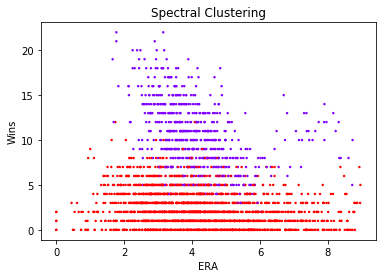

3 Clusters ; 25 KN Graph ; Silhouette Coefficient: 0.5022


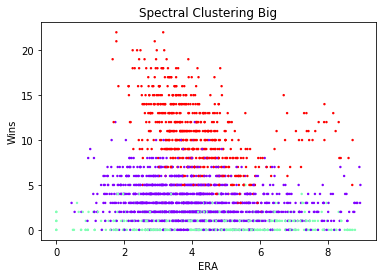

In [7]:
#print(spcKNG.affinity_matrix_)
#print(spcKNG.labels_)

#nclust = 2
#Best Spectral Cluster
Xknn = kneighbors_graph(X, bestKnn)

spcKNG = SpectralClustering(n_clusters=bestClust, affinity = 'precomputed')
labelsSC = spcKNG.fit_predict(Xknn)
#print(len(labels))

plt.scatter(X[:, 14], X[:, 0], c=labelsSC, cmap=plt.cm.rainbow, s=6, linewidths=0)
print(bestClust, "Clusters ;", bestKnn, "KN Graph", "; Silhouette Coefficient: %0.4f" % metrics.silhouette_score(X, labelsSC))
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title('Spectral Clustering')
plt.savefig('./plots/SC.png')
plt.show()

#Best Spectral Cluster with > 2 Clusters
Xknn = kneighbors_graph(X, bestBigKnn)

spcKNG = SpectralClustering(n_clusters=bestBigClust, affinity = 'precomputed')
labels = spcKNG.fit_predict(Xknn)
#print(len(labels))

plt.scatter(X[:, 14], X[:, 0], c=labels, cmap=plt.cm.rainbow, s=6, linewidths=0)
print(bestBigClust, "Clusters ;", bestBigKnn, "KN Graph", "; Silhouette Coefficient: %0.4f" % metrics.silhouette_score(X, labels))
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title('Spectral Clustering Big')
plt.savefig('./plots/SC2.png')
plt.show()

### Hierarchical Agglomerative Clustering
#### Train and Adjust Parameters
This section will determine which combination of linkage and number of clusters produces the optimal Hierarchical Agglomerative Clustering result as measured by the Silhouette Coefficient.  This section will track the model with the best overall score as well as the best model with more than two clusters.  

In [8]:
%%time 

bestSil = 0
bestBigSil = 0

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(2,6):
        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(pitchingSC)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering
        silScore = metrics.silhouette_score(pitchingSC, newfeature_fam)
        print(n_fam, "Clusters", "; Linkage:", link, "; Silhouette Coefficient: %0.4f" % silScore)
        if (silScore > bestSil):
            bestSil = silScore
            bestClust = n_fam
            bestLink = link
        elif (n_fam > 2):
            if (silScore > bestBigSil):
                bestBigSil = silScore
                bestBigClust = n_fam
                bestBigLink = link        
                #print(bestBigSil, bestBigClust, bestBigLink)
                
clustResults.append({'Model': 'Hierarchical Agglomerative Clustering', 'Silhouette_Score': bestSil, 'Clusters': bestClust, 'GT2_Silhouette_Score': bestBigSil, 'GT2_Clusters': bestBigClust, 'BIC': 0.0})

2 Clusters ; Linkage: ward ; Silhouette Coefficient: 0.6986
3 Clusters ; Linkage: ward ; Silhouette Coefficient: 0.6084
4 Clusters ; Linkage: ward ; Silhouette Coefficient: 0.5490
5 Clusters ; Linkage: ward ; Silhouette Coefficient: 0.5115
2 Clusters ; Linkage: complete ; Silhouette Coefficient: 0.6923
3 Clusters ; Linkage: complete ; Silhouette Coefficient: 0.6210
4 Clusters ; Linkage: complete ; Silhouette Coefficient: 0.4985
5 Clusters ; Linkage: complete ; Silhouette Coefficient: 0.4785
2 Clusters ; Linkage: average ; Silhouette Coefficient: 0.6701
3 Clusters ; Linkage: average ; Silhouette Coefficient: 0.6054
4 Clusters ; Linkage: average ; Silhouette Coefficient: 0.5147
5 Clusters ; Linkage: average ; Silhouette Coefficient: 0.5038
Wall time: 6.34 s


#### Visualize Hierarchical Agglomerative Clustering Results

Below, we are visualizing the Hierarchical Agglomerative Clustering results using the optimal clustering parameters.

2 Clusters ; Linkage: ward ; Silhouette Coefficient: 0.6986


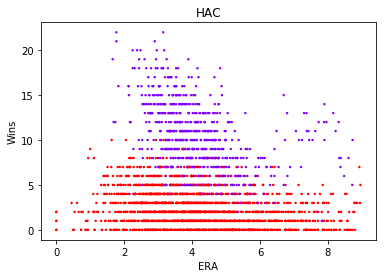

3 Clusters ; Linkage: complete ; Silhouette Coefficient: 0.6210


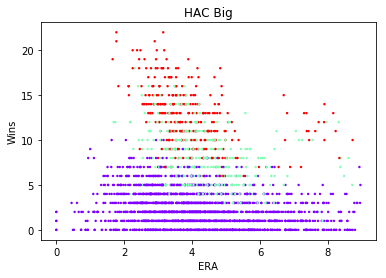

In [9]:
#Best HAC Model
cls_fam = AgglomerativeClustering(n_clusters=bestClust, linkage=bestLink)
cls_fam.fit(pitchingSC)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering
print(bestClust, "Clusters ;", "Linkage:", bestLink, "; Silhouette Coefficient: %0.4f" % metrics.silhouette_score(pitchingSC, newfeature_fam))

plt.scatter(pitchingSC.ERA, pitchingSC.W, c=newfeature_fam, cmap=plt.cm.rainbow, s=6, linewidths=0)
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title('HAC')
plt.savefig('./plots/HAC.png')
plt.show()

#Best HAC Model with > 2 Clusters
cls_fam = AgglomerativeClustering(n_clusters=bestBigClust, linkage=bestBigLink)
cls_fam.fit(pitchingSC)
newfeature_famSV = cls_fam.labels_ # the labels from kmeans clustering
print(bestBigClust, "Clusters ;", "Linkage:", bestBigLink, "; Silhouette Coefficient: %0.4f" % metrics.silhouette_score(pitchingSC, newfeature_famSV))

plt.scatter(pitchingSC.ERA, pitchingSC.W, c=newfeature_famSV, cmap=plt.cm.rainbow, s=6, linewidths=0)
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title('HAC Big')
plt.savefig('./plots/HAC2.png')
plt.show()

### HDBSCAN
#### Train and Adjust Parameters
HDBSCAN is a relatively new clustering algorithm created by the makers of DBSCAN.  The best HDBSCAN model will be produces by testing various combinations of minimum cluster size and minimal sample size.

This section will determine which combination of minimum cluster size and minimal sample size that produces the optimal HDBSCAN Clustering result as measured by the Silhouette Coefficient.  This section will track the model with the best overall score. 

In [10]:
%%time 

bestSil = 0

params = []
for mcs in range(10,60,10):
    for ms in range(1, 6, 1):
        cls_hdbs = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        cls_hdbs.fit(pitchingSC)
        labelsHdbs = cls_hdbs.labels_ # the labels from kmeans clustering
        silScore = metrics.silhouette_score(pitchingSC, labelsHdbs)
        print(mcs, "Min Cluster Size", ms, "Min Samples", "Silhouette Coefficient: %0.4f" % silScore)
        if (silScore > bestSil):
            bestSil = silScore
            bestMCS = mcs
            bestMS = ms

10 Min Cluster Size 1 Min Samples Silhouette Coefficient: -0.3040
10 Min Cluster Size 2 Min Samples Silhouette Coefficient: -0.3157
10 Min Cluster Size 3 Min Samples Silhouette Coefficient: -0.3071
10 Min Cluster Size 4 Min Samples Silhouette Coefficient: -0.2585
10 Min Cluster Size 5 Min Samples Silhouette Coefficient: -0.1835
20 Min Cluster Size 1 Min Samples Silhouette Coefficient: -0.2381
20 Min Cluster Size 2 Min Samples Silhouette Coefficient: 0.3078
20 Min Cluster Size 3 Min Samples Silhouette Coefficient: -0.1625
20 Min Cluster Size 4 Min Samples Silhouette Coefficient: -0.1672
20 Min Cluster Size 5 Min Samples Silhouette Coefficient: -0.1642
30 Min Cluster Size 1 Min Samples Silhouette Coefficient: -0.0713
30 Min Cluster Size 2 Min Samples Silhouette Coefficient: -0.1284
30 Min Cluster Size 3 Min Samples Silhouette Coefficient: -0.1701
30 Min Cluster Size 4 Min Samples Silhouette Coefficient: -0.1531
30 Min Cluster Size 5 Min Samples Silhouette Coefficient: -0.1445
40 Min Clus

#### Visualize HDBSCAN Results
Below, we are visualizing the HDBSCAN Clustering results using the optimal clustering parameters.

40 Min Cluster Size; 4 Min Samples; Silhouette Coefficient: 0.4395


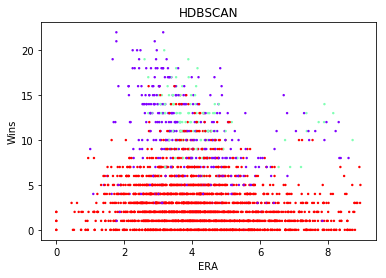

In [11]:
#Best HAC Model
cls_hdbs = hdbscan.HDBSCAN(min_cluster_size=bestMCS, min_samples=bestMS)
cls_hdbs.fit(pitchingSC)
labelsHdbs = cls_hdbs.labels_ 
print(bestMCS, "Min Cluster Size;", bestMS, "Min Samples;", "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(pitchingSC, labelsHdbs))

plt.scatter(pitchingSC.ERA, pitchingSC.W, c=labelsHdbs, cmap=plt.cm.rainbow, s=6, linewidths=0)
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title('HDBSCAN')
plt.savefig('./plots/Hdbscan.png')
plt.show()

clustCount = np.unique(labelsHdbs)
clustResults.append({'Model': 'HDBSCAN', 'Silhouette_Score': bestSil, 'Clusters': len(clustCount), 'GT2_Silhouette_Score': 0, 'GT2_Clusters': 0, 'BIC': 0.0})

### Gaussian Mixture Models
This section will determine which combination of number of components, covariance type and paramter type produces the optimal GMM Clustering result as measured by the BIC and/or Silhouette Coefficient.
Maximum iterations and random state will be fixed at 200 and 42, respectively.

In [12]:
%%time
# this code has been manipulated from the source available on sklearn's website documentation
bestSil = 0
lowest_bic = np.infty
bic = []
n_components_range = range(8,18)
cv_types = ['spherical','tied', 'diag', 'full']
in_parm_types = ['random','kmeans']
for in_parm_type in in_parm_types:
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a mixture of Gaussians with EM
            gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type, init_params=in_parm_type, max_iter=200, random_state=42)
            gmm.fit(pitchingSC)
            gmmLabels = gmm.predict(pitchingSC)
            silScore = metrics.silhouette_score(pitchingSC, gmmLabels)
            bic.append(gmm.bic(pitchingSC))
            print(n_components, "Components;", cv_type, "Covariance Type;", in_parm_type, "Params;", 'BIC %.2f' % bic[-1], '; Sil. Score %.4f' % silScore)
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                lowest_bic_silScore = silScore
                best_gmm = gmm
            if (silScore > bestSil):
                bestSil = silScore
                bestSil_bic = gmm.bic(pitchingSC)

#clustResults.append({'Model': 'Gaussian Mixture Models', 'Silhouette_Score': bestSil, 'GT2_Silhouette_Score': 0, 'BIC': lowest_bic})

8 Components; spherical Covariance Type; random Params; BIC 525150.54 ; Sil. Score 0.3896
9 Components; spherical Covariance Type; random Params; BIC 519196.81 ; Sil. Score 0.3734
10 Components; spherical Covariance Type; random Params; BIC 511988.91 ; Sil. Score 0.3423
11 Components; spherical Covariance Type; random Params; BIC 505543.90 ; Sil. Score 0.3362
12 Components; spherical Covariance Type; random Params; BIC 505753.34 ; Sil. Score 0.3362
13 Components; spherical Covariance Type; random Params; BIC 498312.41 ; Sil. Score 0.3244
14 Components; spherical Covariance Type; random Params; BIC 494334.32 ; Sil. Score 0.3188
15 Components; spherical Covariance Type; random Params; BIC 490739.23 ; Sil. Score 0.3008
16 Components; spherical Covariance Type; random Params; BIC 490077.17 ; Sil. Score 0.2944
17 Components; spherical Covariance Type; random Params; BIC 484675.85 ; Sil. Score 0.2837
8 Components; tied Covariance Type; random Params; BIC 265877.73 ; Sil. Score -0.1547
9 Comp

In [13]:
print('The optimal model parameters, based on lowest BIC value:')
print(best_gmm)
#print(bic)
print('\nLowest BIC: %.2f' % lowest_bic,'; Corresponding Silhouette Score: %.4f' %lowest_bic_silScore,'\nBest Silhouette Score: %.4f' % bestSil,'; Corresponding BIC Score: %.2f' % bestSil_bic)

The optimal model parameters, based on lowest BIC value:
GaussianMixture(covariance_type='full', init_params='random', max_iter=200,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

Lowest BIC: 134968.43 ; Corresponding Silhouette Score: -0.0758 
Best Silhouette Score: 0.3896 ; Corresponding BIC Score: 525150.54


NOTE:  The Lowest BIC Score and Best Silhouette Scores do not occur with the same GMM model parameters.
  
  

#### GMM BIC Bar Chart
The bar chart displayed below provides a graphical method to view the BIC scores of the various Guassian Mixture Model combinations created above.  An asterisk above the bar with the lowest BIC score denotes the best GMM model.

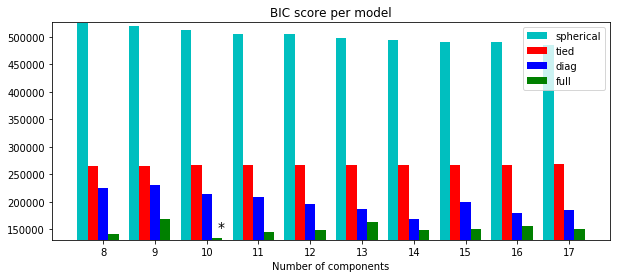

In [14]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['c', 'r', 'b', 'g', 'k', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

#### Display GMM Cluster Graph
Below, we are visualizing the GMM Clustering results using the optimal clustering parameters, according to min BIC score.

GaussianMixture(covariance_type='full', init_params='random', max_iter=200,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


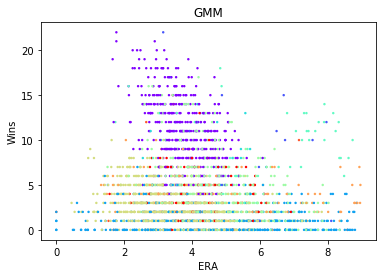

In [15]:
#Best GMM Model
gmm = mixture.GaussianMixture(covariance_type='full', init_params='random', max_iter=200,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
gmm.fit(pitchingSC)
gmmLabels = gmm.predict(pitchingSC)

clustCount = np.unique(gmmLabels)

print(best_gmm)

plt.scatter(pitchingSC.ERA, pitchingSC.W, c=gmmLabels, cmap=plt.cm.rainbow, s=6, linewidths=0)
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.title("GMM")
plt.savefig('./plots/Gmm.png')
plt.show()

clustResults.append({'Model': 'Gaussian Mixture Model', 'Silhouette_Score': bestSil, 'Clusters': len(clustCount), 'GT2_Silhouette_Score': 0, 'GT2_Clusters': 0, 'BIC': lowest_bic})

---
## Modeling and Evaluation 2
The models generated in "Modeling and Evaluation 1" will be compared using visual examination and common metrics, to determine the best model(s) to use for analyzing pitcher clusters.  The optimal parameters and scoring metrics from each of the clustering techniques developed in "Modeling and Evaluation 1" is stored in a list named "clustResults".
This section begins by transforming the list into a data frame for display purposes.

The following guideline for evaluating silhouette scores is as follows score >= 0.70 is a strong model, 0.50 - 0.69 is an usable model, 0.26 - 0.49 is a weak model and < 0.25 is generally unusable.  This guideline can be found at https://www.stat.berkeley.edu/~spector/s133/Clus.html.

The table shows the best overall model is the Spectral Clustering model with which happened to have two clusters with a silhouette score of 0.7097.  However, the Hierarchical Agglomerative Clustering model produced good results for both a two cluster model (0.6986) and a three cluster model (0.6210).

The column titled "GT2_Silhouette_Score" shows the best silhouette score achieved by a model with more than two clusters.  This column is utilized for those models where the number of clusters was specified or varied expressly via code.  The three cluster Hierarchical Agglomerative Clustering model may prove useful as the third cluster may provide an extra level of granularity which may be useful in evaluating pitchers.  
#### Metric Table

In [16]:
#Convert cluster results list to data frame.
dfClustResults = pd.DataFrame(clustResults)
dfClustResults = dfClustResults[['Model', 'Silhouette_Score', 'Clusters', 'GT2_Silhouette_Score', 'GT2_Clusters', 'BIC']]
dfClustResults.round(4)

,Model,Silhouette_Score,Clusters,GT2_Silhouette_Score,GT2_Clusters,BIC
0,Spectral Clustering,0.7097,2,0.5022,3,0.0000
1,Hierarchical Agglomerative Clustering,0.6986,2,0.6210,3,0.0000
2,HDBSCAN,0.4395,3,0.0000,0,0.0000
3,Gaussian Mixture Model,0.3896,10,0.0000,0,134968.4338


#### Visual Model Comparison

The Wins versus ERA scatter plots for all models, grouped by clusters are displayed below.  

Examination of the top performing Spectral Clustering plot titled "Spectral Clustering" shows two defined clusters.  Well defined globular clusters do not appear to exist for pitchers.  However, Spectral Clustering did create clusters with minimal overlap.

The Hierarchical Agglomerative Clustering (HAC) model with two clusters produces results very similar to the spectral clustering model.  The "HAC Big" plot show a third cluster.  Separation between the red and green clusters appears to be an issue.  However, the silhouette score indicates this is a strong model.  As stated previously, the addition of a third cluster could provide interesting detail and a layer of definition between starters, middle relievers and closers.  

Visual analysis of the HDBSCAN model with 3 clusters and Gaussian Mixture Model (GMM) with 10 clusters do not appear to have well defined clusters.  This is backed up by the low silhouette scores 0.4395 and 0.3896 respectively. According to guidelines, these models are weak.  
The HDBSCAN model cluster sizes are disproportional, with the majority of the observations clustered in a single cluster (red), while the remaining observations (cyan, magenta) are clustered at the perimeter (extremes) of the observations.  
The GMM model clusters do appear to be relatively proportional in size.  Some of the clusters are not well defined.  A good example is the (red) cluster, which is scattered throughout and within neighboring clusters. 

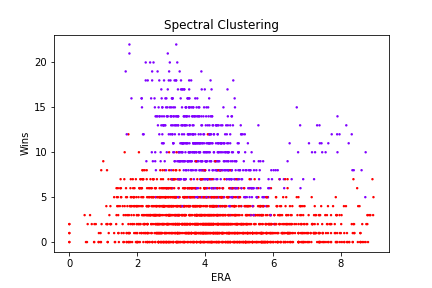

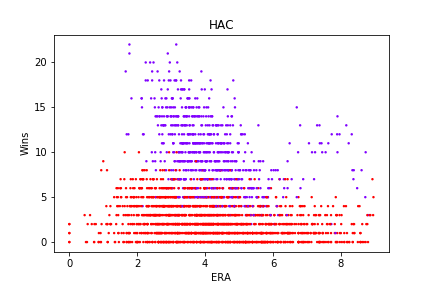

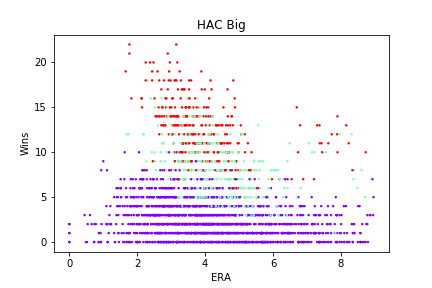

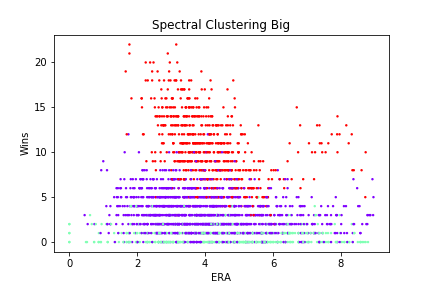

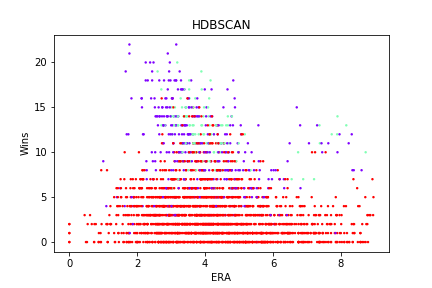

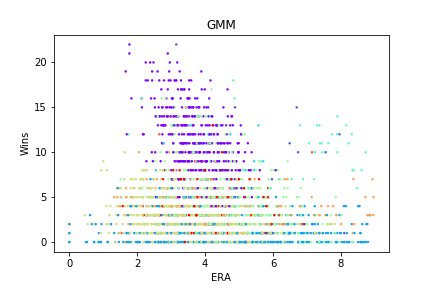

In [17]:
plots = ["./plots/SC.png", "./plots/HAC.png", "./plots/HAC2.png", "./plots/SC2.png", "./plots/Hdbscan.png",  "./plots/Gmm.png"]

for p in plots:
    display(Image.open(p))

#### Models to Examine in Additional Detail

The top performing Spectral Clustering Model and, for reasons listed above, the HAC model with three clusters will be examined in further detail.

---
## Modeling and Evaluation 3
This section will focus on visualizing the results of the two cluster Spectral Cluster and three cluster Hierarchical Agglomerative Clustering (HAC) models described in the prior two sections.  Cluster scatter plots by Wins and ERA have been generated, presented and analyzed in "Modeling and Evaluation 2".  These will not be regenerated in this section.  A dendrogram would be a nice way to visualize the results of HAC.  However, the subset data size is too large to generate a readable dendrogram.  Instead, the focus of this section will be on producing new methods to examine clustering results.

#### Similarity Matrix Plotting Function

In [18]:
### Credit to:  https://github.com/eclarson/DataMiningNotebooks/blob/master/10.%20Clustering%20Validity.ipynb

def plotSimMatrix(lab, title, data):
    y=lab
    idx_sorted = np.argsort(y,kind="quicksort")  # need to get the ordering of Y
    data_sorted = data[idx_sorted]  # sort the dataset by class
    R = pairwise.euclidean_distances(data_sorted)  # calculate the similarity

    #transform distance to similarity
    min_r = np.min(R)
    max_r = np.max(R)
    R = 1-(R-min_r)/(max_r-min_r)

    plt.figure(figsize=(15,10))
    plt.pcolormesh(R)
    plt.colorbar()

    # plot class boundaries
    bounds = np.cumsum([np.sum(y==val) for val in np.unique(y)])
    for b in bounds:
        plt.plot([b,b],[0, len(y)],'k',linewidth=1)
        plt.plot([0, len(y)],[b,b],'k',linewidth=1)

    plt.title(title)
    plt.show()

#### Similarity Plot Analysis

The similarity plots are color coded to show how similar one observation is to all other observations in the data set.  In order from most similar to least similar, the color scale for the charts shown below goes from yellow to green to blue to purple.  With approximately 2400 pitcher records remaining in the data set, it is not practical to use the similarity matrix for pitcher to pitcher analysis.  However, clusters of similarity and the general degree of similarity can be observed by viewing the plots. 

Visual examination of the "Spectral Clustering - 2 Clusters" plot clearly show the two clusters identified by the model.  These are a greenish-yellow color in the 0.8 range.  The boxes showing dissimilar observations appear to have a color score somewhere between 0.4 and 0.6.  The clusters are fairly well defined in the plot.  The "HAC - 3 Clusters" plot identifies the three well defined clusters identified by the Hierarchical Agglomerative Clustering algorithm.  

In general, the similar clusters in this plot appear to be more yellow compared tot he Spectral Clustering plot.  This would suggest the clusters are more cohesive.  However, a greater portion of the HAC graph falls into the green to purple color spectrum when compared to the Spectral Clustering plot.  This seems to coincide with the Silhouette score of 0.7097 for Spectral Clustering and 0.6210 for the three cluster HAC model.  

In the end, both models could be useful for evaluating pitchers.  The Spectral clustering model would be a bit more inclusive in terms of the number of highly similar observations while the HAC model would provide more cohesive clusters with higher similarity.  With the subject matter being pitchers, a tradeoff between cluster inclusion for higher cohesion may be suitable.

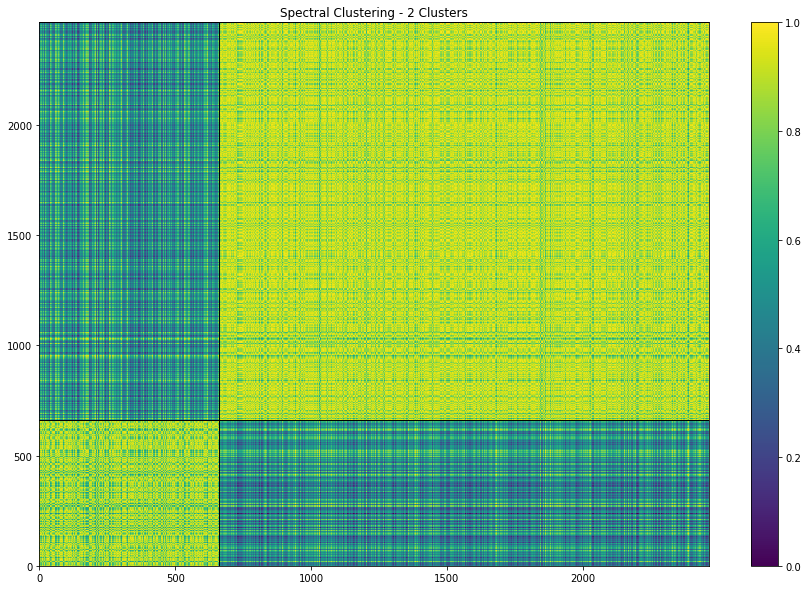

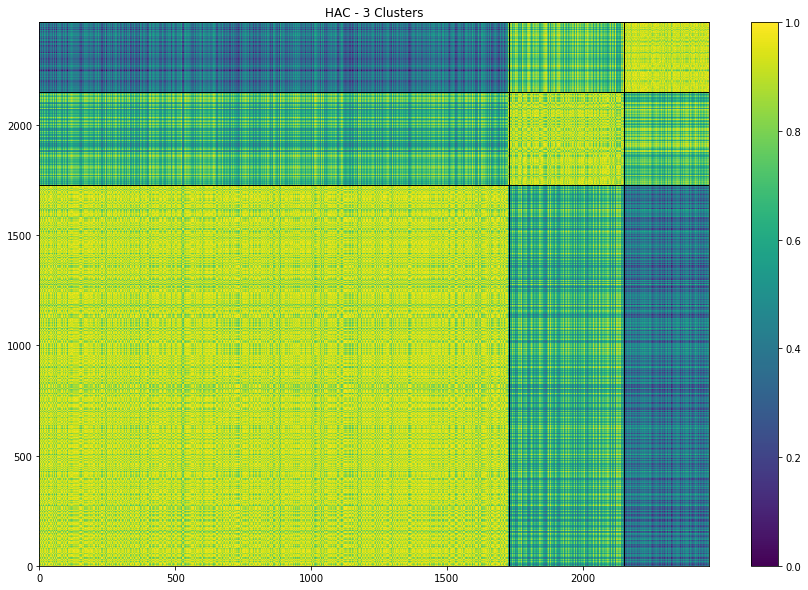

Wall time: 12 s


In [19]:
%%time
#Spectral Clustering Similarity Matrix
plotSimMatrix(labelsSC, "Spectral Clustering - 2 Clusters", X)

#HAC Similariy Matrix
plotSimMatrix(newfeature_famSV, "HAC - 3 Clusters", X)

#GMM Similarity Matrix
#plotSimMatrix(gmmLabels, "GMM", X)

## Modeling and Evaluation 4
#### What do the clusters indicate?
Elite starters, average starters and middle relievers 


#### How can the clusters be used?
The use case of applying pitcher clusters to make personnel decisions will be examined.  Spectral Clustering and Hierarchical Agglomerative Clustering results will be used to examine pitchers similar to two past Cy Young Award winners:  Max Scherzer and Rick Porcello.  

- Max Scherzer 2016, 2017 NL Cy Young Winner (scherma01)
- Rick Porcello 2016 AL Cy Young Winner (porceri01)

#### Prepare New Data Frame for Analysis

Now that clustering is complete, key information to allow the identification of individual pitchers and their clusters for analysis must be merged back with the data used for clustering.  

We begin by creating data frames from the cluster labels produced by HAC-3 and Spectral Clustering-2 Cluster (SC2) models.  These two label data frames are concatenated into a single data frame. 

The pitchingSC data frame, which was the basis of data input into the clustering models, is concatenated with a data frame containing player demographics and salary information, creating a new data frame named pitchingClust. 

Finally the cluster labels are merged into pitchingClust.  The end result is a data frame which enables pitcher level identification by Hierarchical Agglomerative and Spectral clusters.  The displayed output from this section is a count of pitcher records per cluster.

In [20]:
try:
    del pitchingClust
    #del df
except:
    pass

#Create Data Frame from best > 2 Cluster HAC Model Labels
hac3LabelsDf = pd.DataFrame(newfeature_famSV)
hac3LabelsDf.rename(index=str, columns={0: 'HAC3_Label'}, inplace=True)

#Get Counts for each HAC
df = hac3LabelsDf
df['count1'] = 1
print(df.groupby('HAC3_Label').sum())

#Create Data Frame from best Spectral Clustering Labels
sc2LabelsDf = pd.DataFrame(labelsSC)
sc2LabelsDf.rename(index=str, columns={0: 'SC2_Label'}, inplace=True)

#Get Counts for each Spectral cluster
df = sc2LabelsDf
df['count2'] = 1
print('\n',df.groupby('SC2_Label').sum())

#Combine the two label data frames
labelsDf = pd.concat([hac3LabelsDf, sc2LabelsDf], axis=1)
labelsDf.reset_index(inplace=True, drop=True)

#Concatenate the two dataframes to bring attributes such as playerID and salary back into the attributes used for clustering
pitchingClust = pd.concat([pitchingSC, pitchIDs], axis = 1)
pitchingClust.reset_index(inplace=True)
#print(pitchingClust)

#Add labels to pitchingClust
pitchingClust = pd.concat([pitchingClust, labelsDf], axis = 1, join='inner')
#pitchingClust

            count1
HAC3_Label        
0             1728
1              423
2              315

            count2
SC2_Label        
0             663
1            1803


##### Cluster Observation - Quantities

This observation is not scientific but it is intriguing that HAC3 and SC2 models have similar splits in number of observation in clusters (large cluster - 1728/1803). It looks like both models identified the similar clusters, while the HAC3 model split the smaller SC2 cluster into 2 clusters.  

##### Cy Young Winner - Identifying
The data rows for Cy Young Award winners, Max Scherzer and Rick Porcello are displayed below.

In [21]:
#Find 2016 Cy Young Winners in pitchingClust
#Max Scherzer 2016 NL Cy Young Winner (scherma01)
#Rick Porcello 2016 NL Cy Young Winner (porceri01)
#Corey Kluber, 2017 AL Cy Young Winner (klubeco01)

cyYoung = pitchingClust.loc[(pitchingClust['playerID'] == 'scherma01') | (pitchingClust['playerID'] == 'porceri01')]
cyYoung

,index,W,L,G,GS,CG,SHO,SV,IPouts,H,...,throws_R,throws_S,yearID,playerID,salary,adjSalary2,HAC3_Label,count1,SC2_Label,count2
346,16008,13,8,32,29,1,0,0,531,185,...,1,0,2013,porceri01,5100000.0,5.365200e+06,2,1,0,1
407,16086,21,3,32,32,0,0,0,643,152,...,1,0,2013,scherma01,6725000.0,7.074700e+06,2,1,0,1
819,16690,15,13,32,31,3,3,0,614,211,...,1,0,2014,porceri01,8500000.0,8.797500e+06,2,1,0,1
865,16765,18,5,33,33,1,1,0,661,196,...,1,0,2014,scherma01,15525000.0,1.606837e+07,2,1,0,1
1314,17414,9,15,28,28,0,0,0,516,196,...,1,0,2015,porceri01,12500000.0,1.292500e+07,2,1,0,1
1373,17498,14,12,33,33,4,3,0,686,176,...,1,0,2015,scherma01,17142000.0,1.772483e+07,2,1,0,1
1810,18152,22,4,33,33,3,0,0,669,193,...,1,0,2016,porceri01,20125000.0,2.054762e+07,2,1,0,1
1866,18228,20,7,34,34,1,0,0,685,165,...,1,0,2016,scherma01,22142857.0,2.260786e+07,2,1,0,1
2314,18897,11,17,33,33,2,0,0,610,236,...,1,0,2017,porceri01,0.0,5.350000e+05,2,1,0,1
2369,18974,16,6,31,31,2,0,0,602,126,...,1,0,2017,scherma01,0.0,5.350000e+05,2,1,0,1


#### Spectral Clustering - Pitchers Similar to Porcello and Scherzer

The spectral clustering affinity matrix will be utilized to show the pitchers most similar to Rick Porcello and Matt Scherzer.  

Examination of pitchers identified as be most similar to Rick Porcello has some interesting results.  As one of the game's top pitchers, Rick Porcello is similar to pitchers such as Justin Verlander and Adam Wainright on a year by year basis.  This shouldn't be a surprise.  However, there is a selection of lesser known veterans and young pitchers who show high affinity to Rick Porcello.  Statistically, Clayton Richards (richacl01) is a fairly average pitcher who has played for several teams over his eleven year career.  However, the similarity / high affinity to Rick Porcello could mean Richards is an attractive option for a team looking for an additional starting pitcher for a playoff run or for a short contract.  With a 2018 salary of \$3 Million, Richards is also a good value.  Two potential younger pitchers with a high affinity to Rick Porcello are Marcus Stroman (stromma01) and Collin McHugh (mchugco01).  Both are young pitchers with good statistics showing year to year improvements.  They could both be targets for a team looking to acquire a top three starting pitcher position for any team.  With 2018 salaries of \$5 Million for McHugh and \$6.5 Million for Stroman, they are not exactly cheap, but an argument could be made they have the talent to command eight figure salaries.  

Matt Scherzer is arguably the best pitcher in Major League Baseball.  He has won the NL Cy Young award for two years in a row.  As with Rick Porcello, some of the games best pitchers have a high affinity to Scherzer.  Interestingly, more potential "diamonds in the rough" can be found in the list of pitchers similar to Matt Scherzer.  Specifically, Luis Severino (severlu01), a young pitcher with amazing talent.  He is far from an unknown as he plays for the New York Yankees.  However, his 2018 salary of \$604,975 is not commensurate with his value.  Severino should be a acquisition target for any team looking to add a top line starter.  The similarity to Scherzer should encourage teams to extend an eight figure salary with a reasonable degree of confidence.  Noah Snydergaard (snydeno01) and Jose Fernandez (fernajo01) also show an affinity to Scherzer.  These are two young pitchers as well.  With both making sub \$3 Million salaries, they are attractive options to upgrade any team's pitching staff.  Again, the similarity to Scherzer should provide some level of confidence in extending a long term high value contract to them.  

In [22]:
try:
    del df
except:
    pass

##Find Similar Pitchers from Spectral Cluster Affinity Matrix
#Spectral Clustering Affinity matrix is a scipy.sparse.csr.csr_matrix
#print(pd.DataFrame((spcKNG.affinity_matrix_).todense()))
df = pd.DataFrame((spcKNG.affinity_matrix_).todense())
#print(df)

#Similar to 2016 Porcello
porcello = df.iloc[[2314]]
porcello = porcello.loc[:, (porcello != 0).any(axis=0)]
print("Pitchers Similar to Rick Porcello")
pitchingClust.iloc[porcello.columns, 27:34].head(10)

Pitchers Similar to Rick Porcello


,throws_L,throws_R,throws_S,yearID,playerID,salary,adjSalary2
47,1,0,0,2013,buehrma01,12000000.0,1.262400e+07
141,0,1,0,2013,fistedo01,4000000.0,4.208000e+06
198,1,0,0,2013,hollade01,3400000.0,3.576800e+06
245,1,0,0,2013,lestejo01,11625000.0,1.222950e+07
393,1,0,0,2013,sabatcc01,24285714.0,2.554857e+07
397,0,1,0,2013,samarje01,2640000.0,2.777280e+06
428,1,0,0,2013,stulter01,507600.0,5.339952e+05
572,0,1,0,2014,colonba01,9000000.0,9.315000e+06
608,0,1,0,2014,eovalna01,517000.0,5.350950e+05
665,0,1,0,2014,haranaa01,1000000.0,1.035000e+06


In [23]:
#Similar to Scherzer
scherzer = df.iloc[[2369]]
scherzer = scherzer.loc[:, (scherzer != 0).any(axis=0)]
print("")
print("Pitchers Similar to Matt Scherzer")
pitchingClust.iloc[scherzer.columns, 27:34].head(10)


Pitchers Similar to Matt Scherzer


,throws_L,throws_R,throws_S,yearID,playerID,salary,adjSalary2
48,1,0,0,2013,bumgama01,916667.0,9.643337e+05
50,0,1,0,2013,burneaj01,16500000.0,1.735800e+07
102,0,1,0,2013,darviyu01,9500000.0,9.994000e+06
193,0,1,0,2013,hernafe02,20557143.0,2.162611e+07
274,0,1,0,2013,masteju01,5687500.0,5.983250e+06
407,0,1,0,2013,scherma01,6725000.0,7.074700e+06
705,1,0,0,2014,kershcl01,4000000.0,4.140000e+06
851,0,1,0,2014,rossty01,1980000.0,2.049300e+06
1022,0,1,0,2015,carraca01,2337500.0,2.416975e+06
1054,0,1,0,2015,degroja01,556875.0,5.758088e+05


#### Hierarchical Agglomerative Clustering - Pitchers Similar to Porcello and Scherzer
The three cluster HAC results will be used to identify pitchers similar to Rick Porcello and Matt Scherzer as well.  The approach will be a bit different when compared to Spectral Clustering as a dendrogram will be utilized as the basis for identifying pitchers clustered with Porcello and Scherzer.

Porcello and Scherzer are both in the same cluster computed by the HAC model created in Modeling and Evaluation 1.  A subset of the pitchingClust data frame will be created with pitchers in their cluster.  

In [24]:
#Find Similar Pitchers from HAC Cluster
hacClust = pitchingClust[(pitchingClust.HAC3_Label == 2)]

#Prep hacClust for Agglomerative Clustering
#Save hacClust columns
hacClustSV = hacClust[['playerID', 'salary', 'adjSalary2']]

#Drop columns with no clustering value
hacClust = hacClust.drop(['playerID', 'salary', 'adjSalary2', 'HAC3_Label', 'count', 'SC2_Label', 'count2'], axis=1)

There are 315 pitchers in HAC3 cluster 2.  Comparing 313 other pitchers to Porcello and Scherzer is a daunting task.  So, this cluster will be reclustered using Hierarchical Agglomerative Clustering to create a smaller cluster of pitchers similar to Porcello and Scherzer.  

In [25]:
#Recluster hacClust to find more granular similarities
#Find optimal parms for recluster

bestSil = 0
bestBigSil = 0

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(2,6):
        # append on the clustering
        hac_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        hac_fam.fit(hacClust)
        hacLabels = hac_fam.labels_ 
        silScore = metrics.silhouette_score(hacClust, hacLabels)
        #print(n_fam, "Clusters", "Linkage:", link, "Silhouette Coefficient: %0.4f" % silScore)
        if (silScore > bestSil):
            bestSil = silScore
            bestClust = n_fam
            bestLink = link

hac_fam = AgglomerativeClustering(n_clusters=bestClust, linkage=bestLink)
hac_fam.fit(hacClust)
hacLabels = hac_fam.labels_ # the labels from kmeans clustering
print(bestClust, "Clusters", "Linkage:", bestLink, "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(hacClust, hacLabels))

#Reassemble the hacClust data frame
hacClust = pd.concat([hacClust, hacClustSV], axis = 1)
hacClust.reset_index(inplace=True, drop=True)
#print(hacClust)

2 Clusters Linkage: complete Silhouette Coefficient: 0.5996


Below, we display the pitcher records for Scherzer and Porcello in the new data frame.

In [26]:
#cyYoung2 = hacClust.loc[(hacClust['playerID'] == 'scherma01') | (hacClust['playerID'] == 'porceri01')]
#cyYoung2
hacClust.loc[(hacClust['playerID'] == 'scherma01') | (hacClust['playerID'] == 'porceri01')]

,index,W,L,G,GS,CG,SHO,SV,IPouts,H,...,GIDP,yearID,throws_L,throws_R,throws_S,yearID,count1,playerID,salary,adjSalary2
50,16008,13,8,32,29,1,0,0,531,185,...,20.0,2013,0,1,0,2013,1,porceri01,5100000.0,5.365200e+06
60,16086,21,3,32,32,0,0,0,643,152,...,10.0,2013,0,1,0,2013,1,scherma01,6725000.0,7.074700e+06
120,16690,15,13,32,31,3,3,0,614,211,...,30.0,2014,0,1,0,2014,1,porceri01,8500000.0,8.797500e+06
127,16765,18,5,33,33,1,1,0,661,196,...,15.0,2014,0,1,0,2014,1,scherma01,15525000.0,1.606837e+07
194,17414,9,15,28,28,0,0,0,516,196,...,21.0,2015,0,1,0,2015,1,porceri01,12500000.0,1.292500e+07
204,17498,14,12,33,33,4,3,0,686,176,...,5.0,2015,0,1,0,2015,1,scherma01,17142000.0,1.772483e+07
249,18152,22,4,33,33,3,0,0,669,193,...,16.0,2016,0,1,0,2016,1,porceri01,20125000.0,2.054762e+07
259,18228,20,7,34,34,1,0,0,685,165,...,6.0,2016,0,1,0,2016,1,scherma01,22142857.0,2.260786e+07
300,18897,11,17,33,33,2,0,0,610,236,...,18.0,2017,0,1,0,2017,1,porceri01,0.0,5.350000e+05
307,18974,16,6,31,31,2,0,0,602,126,...,13.0,2017,0,1,0,2017,1,scherma01,0.0,5.350000e+05


##### Create Dendrogram
The code commented out below was used to generate the dendrogram images shown below.  For brevity and document readability, these figures were saved to disk as images and redisplayed.  The "Full Recluster Dendrogram" shows the HAC recluster is total.  As can be seen, a dendrogram with over 300 leaf values can be hard to consume.  So, a zoom in of the pitchers similar to Porcello and Scherzer at branch level 5 is shown as well.  In this figure, Porcello is observation 300.  Scherzer is observation 307.  

Full Recluster Dendrogram


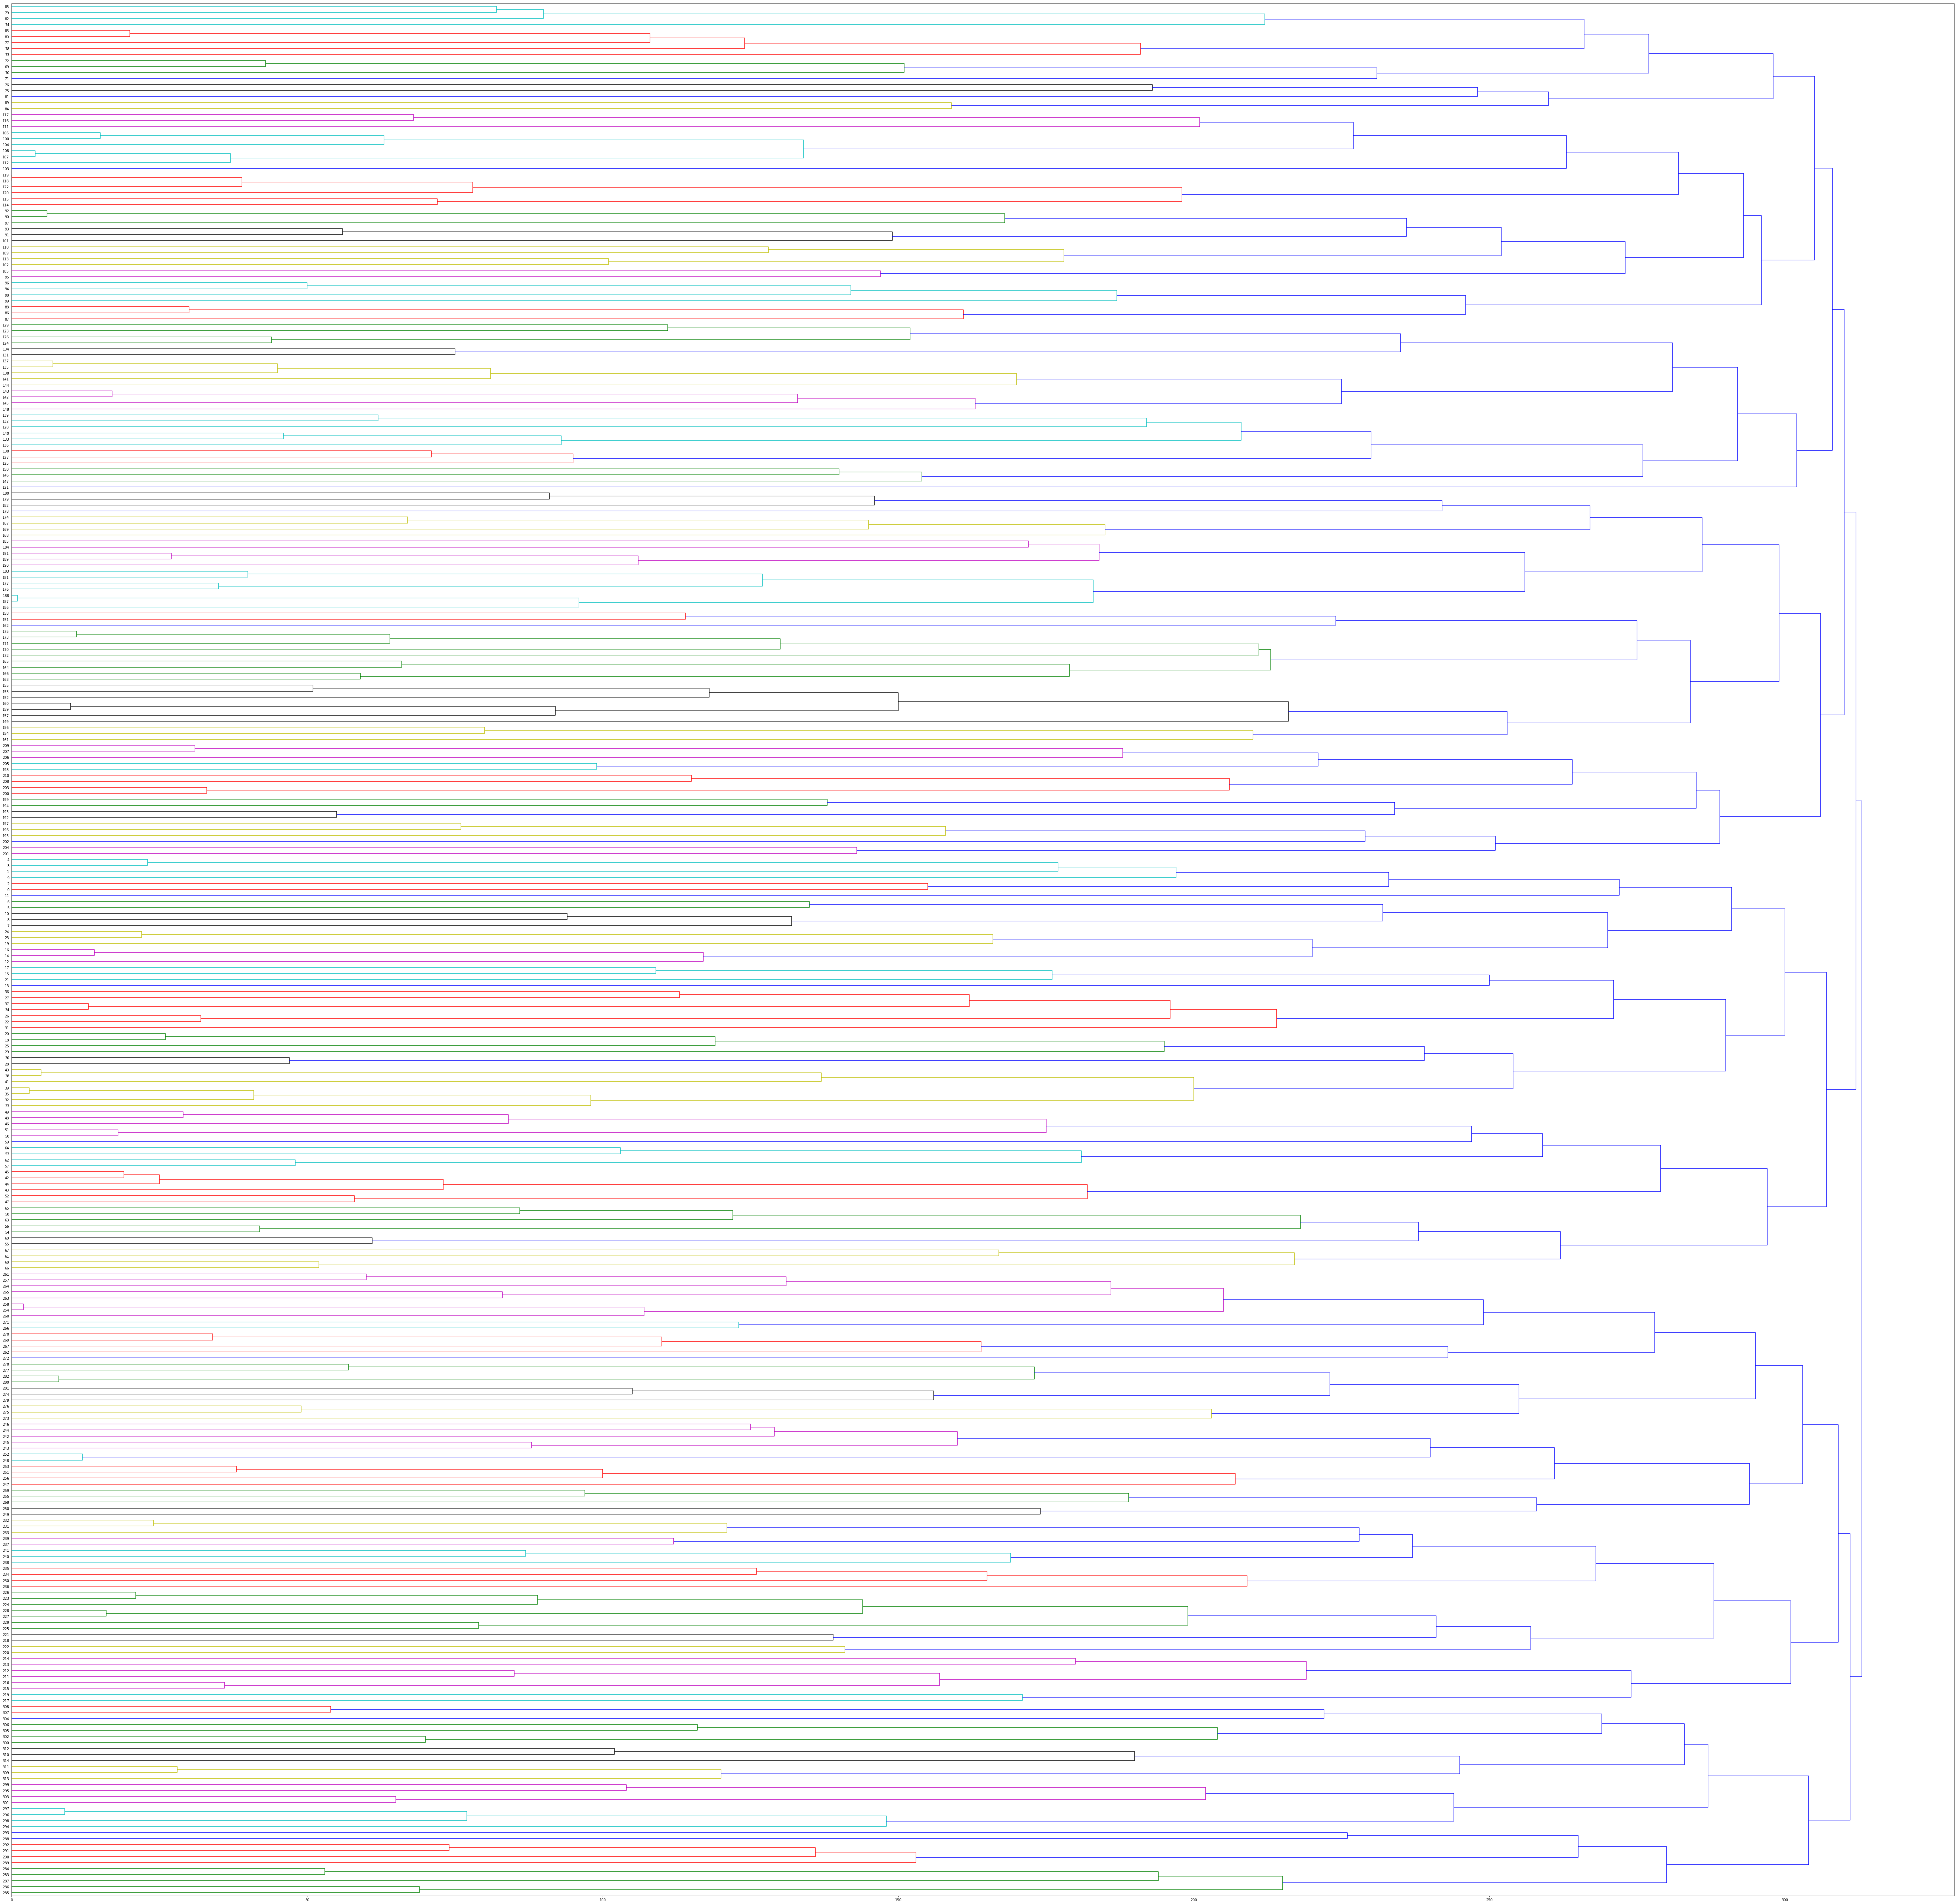

Zoom In Porcello and Scherzer


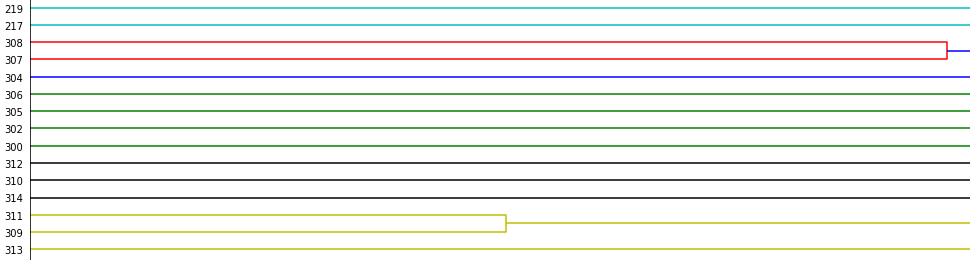

In [27]:
##Credit To:  https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
#from scipy.cluster.hierarchy import dendrogram

#plt.figure(figsize=(100,100))
#children = hac_fam.children_
#distance = np.arange(children.shape[0])
#no_of_observations = np.arange(2, children.shape[0]+2)
#linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
#dendrogram(linkage_matrix, labels=hacClust.index, show_leaf_counts=False, orientation='right', leaf_font_size=10)

plots = ["./plots/hacdend.png", "./plots/hacdendzoom.png"]
titles = ["Full Recluster Dendrogram", "Zoom In Porcello and Scherzer"]

for r in range(0,2):
    print(titles[r])
    display(Image.open(plots[r]))

As can be seen in the figure above, Porcello and Scherzer are in the same branch level 5 family along with twelve other pitchers.  These pitchers are shown below.  This is a fairly elite grouping of pitchers containing Matt Bumgardner, Johnny Cueto, Chris Sale and Justin Verlander.  Several of the names discussed in the Spectral Clustering section such as Luis Severino, Clayton Richards and Marcus Stromman exist in this group as well.  New pitchers not identified by Spectral Clustering are Julio Teheran, Mashahiro Tanaka, Jason Vargas and Ervin Santana.  

These are all pitchers with an extensive professional baseball resume.  They would all be targets for teams looking to bolster their pitching staffs for a playoff run or for a one or two year contract.  With regards to Luis Severino, he is the only pitcher who shares a leaf level group with Matt Scherzer.  This underscores his ability and potential.  With a sub \$1 Million salary, Severino is a incredible value and should be a target for every major league team once he becomes a free agent.

In [28]:
#Find automatic way to find similar pitchers from dendrogram
simPitch = [217, 219, 308, 307, 304, 306, 305, 302, 300, 312, 310, 314, 311, 307, 313]

hacClust.iloc[[217, 219, 308, 304, 306, 305, 302, 312, 310, 314, 311, 313]]

,index,W,L,G,GS,CG,SHO,SV,IPouts,H,...,GIDP,yearID,throws_L,throws_R,throws_S,yearID,count1,playerID,salary,adjSalary2
217,17702,15,9,34,34,4,1,0,680,179,...,15.0,2016,1,0,0,2016,1,bumgama01,9916667.0,1.012492e+07
219,17760,18,5,32,32,5,2,0,659,195,...,13.0,2016,0,1,0,2016,1,cuetojo01,17500000.0,1.786750e+07
308,18981,14,6,31,31,0,0,0,580,150,...,11.0,2017,0,1,0,2017,1,severlu01,0.0,5.350000e+05
304,18961,17,8,32,32,1,0,0,643,165,...,11.0,2017,1,0,0,2017,1,salech01,0.0,5.350000e+05
306,18967,16,8,33,33,5,3,0,634,177,...,8.0,2017,0,1,0,2017,1,santaer01,0.0,5.350000e+05
305,18962,9,15,32,32,1,1,0,623,204,...,11.0,2017,0,1,0,2017,1,samarje01,0.0,5.350000e+05
302,18921,8,15,32,32,2,1,0,592,240,...,32.0,2017,1,0,0,2017,1,richacl01,0.0,5.350000e+05
312,19037,11,13,32,32,0,0,0,565,186,...,15.0,2017,0,1,0,2017,1,teherju01,0.0,5.350000e+05
310,19025,13,9,33,33,2,0,0,603,201,...,34.0,2017,0,1,0,2017,1,stromma01,0.0,5.350000e+05
314,19063,15,8,33,33,0,0,0,618,170,...,12.0,2017,0,1,0,2017,1,verlaju01,0.0,5.350000e+05


#### Summary
The result of pitcher clustering models could prove to be an asset to the front office of any Major League Team.  It could help drive decisions to release, sign or trade pitchers.  Though the clusters where fairly easy to interpret, practical baseball knowledge must be applied in addition to clustering results to make these decisions.  For example, Clayton Richards appearing in both the Spectral Clustering and HAC output does not necessarily mean a team should make an 8 figure salary offer to a journey-man pitcher with a fairly average resume.  Baseball specific domain knowledge must be combined with the results of clustering to make the best decisions.